In [1]:
import numpy as np
from spline import Spline
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
from unicycle_model import *
import math

In [2]:
# obs = [np.array([[2,1.75]]).T, np.array([[3,4]]).T, np.array([[9,7]]).T, np.array([[8,9]]).T]
obs = [np.array([[2,1.75]]).T, np.array([[3,4]]).T, np.array([[5,5]]).T, np.array([[8,7]]).T]
dmin = 1.0

umin = [0.0, -0.5]
umax = [2.0, 0.5]

# endpoints will be kept fixed
init_ctrl_pts = [np.array([[0,0]]).T, np.array([[0,0]]).T, np.array([[0,0]]).T, 
                np.array([[1,1]]).T, 
                np.array([[2,2]]).T, 
                np.array([[3,3]]).T, 
                np.array([[4,4]]).T, 
                np.array([[5,5]]).T, 
                np.array([[6,6]]).T, 
                np.array([[7,7]]).T, 
                np.array([[8,8]]).T, 
                np.array([[9,9]]).T, 
                np.array([[10,10]]).T, np.array([[10,10]]).T, np.array([[10,10]]).T]
# print(init_ctrl_pts)
# print(len(init_ctrl_pts))
init_knot_space = 1.0
init_knot_pts = (np.array([-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])*init_knot_space).tolist() # evaluatable from 0 to 12
# print(init_knot_pts)
# print(len(init_knot_pts))
cons_eval_pts = np.linspace(0, 1-1e-6, 400).tolist()
# print(cons_eval_pts[-4])
# print(len(cons_eval_pts))

x0 = []
for i in range(len(init_ctrl_pts)-6):
    x0 += init_ctrl_pts[i+3].flatten().tolist().copy()
x0.append(init_knot_space)

# print(x0)
# print(len(x0))

In [3]:
def obj(x):
  J = x[-1]
  g = np.zeros(x.shape)
  g[-1] = 1
  # print(x[-1])
  return J, g

In [4]:
def obs_cons(x):
  con = []

  ctrl_pts = init_ctrl_pts.copy()
  ctrl_pts[3:len(init_ctrl_pts)-3] = [np.array([[x[2*i], x[2*i+1]]]).T for i in range((len(x)-1)//2)]
  knot_pts = (np.array(init_knot_pts)/init_knot_space * x[-1]).tolist()
  spline = Spline(ctrl_pts, knot_pts)

  tf = knot_pts[-4]
  # print("obs_cons")
  # print(tf)
  for i in range(len(obs)):
    for j in range(len(cons_eval_pts)):
      con.append(np.linalg.norm(spline.evaluate(cons_eval_pts[j]*tf) - obs[i])**2) # why is eval_pts[j]*tf and to obs?

  return con
  
def obs_cons_jac(x):
  ctrl_pts = init_ctrl_pts.copy()
  ctrl_pts[3:len(init_ctrl_pts)-3] = [np.array([[x[2*i], x[2*i+1]]]).T for i in range((len(x)-1)//2)]
  knot_pts = (np.array(init_knot_pts)/init_knot_space * x[-1]).tolist()
  spline = Spline(ctrl_pts, knot_pts)

  tf = knot_pts[-4]
  # print("obs_cons_jac")
  # print(tf)
  jac = np.zeros((len(obs)*len(cons_eval_pts), len(x)))
  for i in range(len(obs)):
    for j in range(len(cons_eval_pts)):
      p_t = spline.evaluate(cons_eval_pts[j]*tf)
      for k in range(len(ctrl_pts)-6):
        spl_jac = spline.get_cp_jacobian(k+3, cons_eval_pts[j]*tf)
        jac[i*len(cons_eval_pts)+j, 2*k:2*k+2] = 2*(p_t - obs[i]).T @ spl_jac
      
      # dt_ddeltat = cons_eval_pts[j]*(len(knot_pts)-6)
      jac[i*len(cons_eval_pts)+j, -1] = 0.0 #2*(p_t - obs[i]).T @ (spline.get_dt_jacobian(cons_eval_pts[j]*tf) + spline.evaluate(cons_eval_pts[j]*tf, 1)*dt_ddeltat)

  return jac

In [5]:
obs_nlc = NonlinearConstraint(obs_cons, dmin**2, np.inf, jac=obs_cons_jac)

In [6]:
def inp_cons(x):
  con = []

  ctrl_pts = init_ctrl_pts.copy()
  ctrl_pts[3:len(init_ctrl_pts)-3] = [np.array([[x[2*i], x[2*i+1]]]).T for i in range((len(x)-1)//2)]
  knot_pts = (np.array(init_knot_pts)/init_knot_space * x[-1]).tolist()
  spline = Spline(ctrl_pts, knot_pts)

  tf = knot_pts[-4]
  for i in range(len(cons_eval_pts)):
    inp = unicycle_flat_inputs(spline.evaluate(cons_eval_pts[i]*tf, 1), spline.evaluate(cons_eval_pts[i]*tf, 2))
    con += inp.flatten().tolist()

  return con

def inp_cons_jac(x):
  ctrl_pts = init_ctrl_pts.copy()
  ctrl_pts[3:len(init_ctrl_pts)-3] = [np.array([[x[2*i], x[2*i+1]]]).T for i in range((len(x)-1)//2)]
  knot_pts = (np.array(init_knot_pts)/init_knot_space * x[-1]).tolist()
  spline = Spline(ctrl_pts, knot_pts)

  tf = knot_pts[-4]
  jac = np.zeros((2*len(cons_eval_pts), len(x)))
  for i in range(len(cons_eval_pts)):
    vel = spline.evaluate(cons_eval_pts[i]*tf, 1)
    acc = spline.evaluate(cons_eval_pts[i]*tf, 2)
    jer = spline.evaluate(cons_eval_pts[i]*tf, 3)
    _, jac_v, jac_a = unicycle_flat_inputs(vel, acc, jac=True)
    for j in range(len(ctrl_pts)-6):
      spl_jac_v = spline.get_cp_jacobian(j+3, cons_eval_pts[i]*tf, 1)
      spl_jac_a = spline.get_cp_jacobian(j+3, cons_eval_pts[i]*tf, 2)
      jac[2*i:2*i+2, 2*j:2*j+2] = jac_v @ spl_jac_v + jac_a @ spl_jac_a

    # dt_ddeltat = cons_eval_pts[i]*(len(knot_pts)-6)
    # jac[2*i:2*i+2, [-1]] = jac_v @ (spline.get_dt_jacobian(cons_eval_pts[i]*tf, 1) + acc*dt_ddeltat) + jac_a @ (spline.get_dt_jacobian(cons_eval_pts[i]*tf, 2) + jer*dt_ddeltat)
    jac[2*i:2*i+2, [-1]] = jac_v @ spline.get_dt_jacobian(cons_eval_pts[i]*tf, 1, set_du_ddeltat_zero=True) + jac_a @ spline.get_dt_jacobian(cons_eval_pts[i]*tf, 2, set_du_ddeltat_zero=True)

  return jac

In [7]:
inp_nlc = NonlinearConstraint(inp_cons, umin*len(cons_eval_pts), umax*len(cons_eval_pts), jac=inp_cons_jac)

In [8]:
res = minimize(obj, x0, method='SLSQP', bounds=[(-np.inf, np.inf) for i in range(len(x0)-1)] + [(0.05, 5.0)], jac=True, constraints=[inp_nlc, obs_nlc])
# res = minimize(obj, x0, method='SLSQP', bounds=[(-np.inf, np.inf) for i in range(len(x0)-1)] + [(0.05, 5.0)], jac=True, constraints=[obs_nlc])
xf = res.x
print(res.success)
print(res.message)

/home/jj/Work/bspline_opt/unicycle_model.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  [(-1.0/np.linalg.norm(vd)**2 * vd.T @ SO2.hat(1) @ ad).item(0)]])
/home/jj/Work/bspline_opt/unicycle_model.py:12: RuntimeWarning: invalid value encountered in multiply
  [(-1.0/np.linalg.norm(vd)**2 * vd.T @ SO2.hat(1) @ ad).item(0)]])
/home/jj/Work/bspline_opt/unicycle_model.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  jac_v = np.vstack([1.0/np.linalg.norm(vd) * vd.T,
/home/jj/Work/bspline_opt/unicycle_model.py:16: RuntimeWarning: invalid value encountered in multiply
  jac_v = np.vstack([1.0/np.linalg.norm(vd) * vd.T,
/home/jj/Work/bspline_opt/unicycle_model.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  1.0/np.linalg.norm(vd)**2 * ad.T @ SO2.hat(1) - 2.0/np.linalg.norm(vd)**4 * vd.T * (ad.T @ SO2.hat(1) @ vd)])
/home/jj/Work/bspline_opt/unicycle_model.py:17: RuntimeWarning: invalid value encountered in multiply
  1.0/np.linalg

True
Optimization terminated successfully


/home/jj/Work/bspline_opt/unicycle_model.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  [(-1.0/np.linalg.norm(vd)**2 * vd.T @ SO2.hat(1) @ ad).item(0)]])
/home/jj/Work/bspline_opt/unicycle_model.py:12: RuntimeWarning: invalid value encountered in multiply
  [(-1.0/np.linalg.norm(vd)**2 * vd.T @ SO2.hat(1) @ ad).item(0)]])


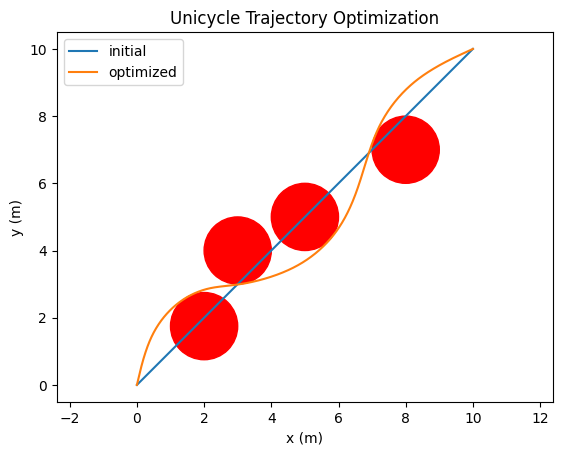

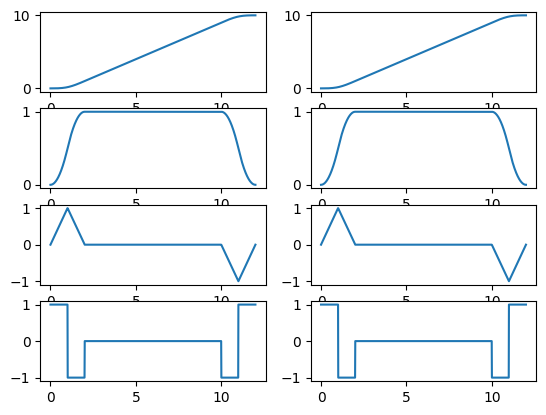

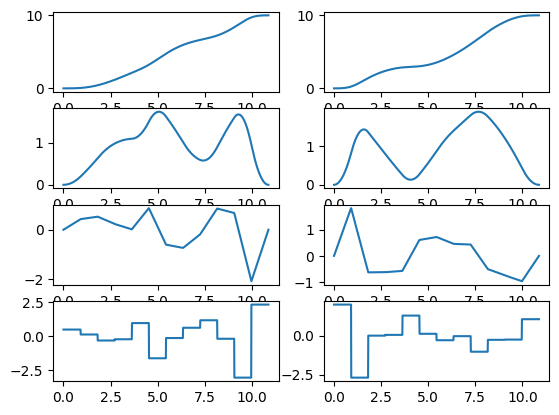

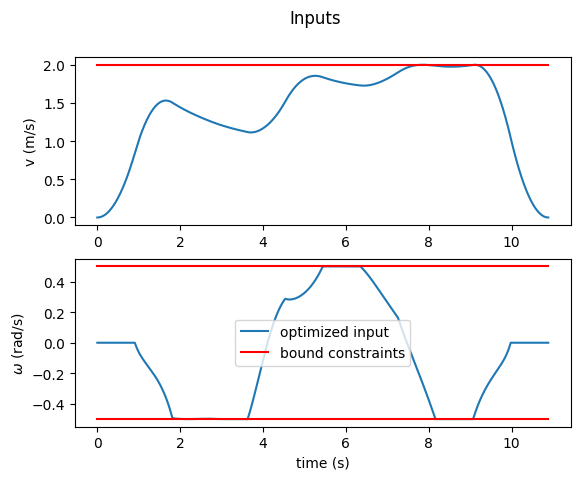

In [9]:
opt_ctrl_pts = init_ctrl_pts.copy()
opt_ctrl_pts[3:len(init_ctrl_pts)-3] = [np.array([[xf[2*i], xf[2*i+1]]]).T for i in range((len(xf)-1)//2)]
opt_knot_pts = (np.array(init_knot_pts)/init_knot_space * xf[-1]).tolist()
opt_spline = Spline(opt_ctrl_pts, opt_knot_pts)
opt_t_vec = np.linspace(0, opt_knot_pts[-4]-1e-6, 1000)
opt_s_eval = [opt_spline.evaluate(t) for t in opt_t_vec]
opt_x = [p.item(0) for p in opt_s_eval]
opt_y = [p.item(1) for p in opt_s_eval]

init_t_vec = np.linspace(0, init_knot_pts[-4]-1e-6, 1000)
init_spline = Spline(init_ctrl_pts, init_knot_pts)
init_s_eval = [init_spline.evaluate(t) for t in init_t_vec]
init_x = [p.item(0) for p in init_s_eval]
init_y = [p.item(1) for p in init_s_eval]

obstacle_plot = [plt.Circle(c, dmin, color='r') for c in obs]
for circle in obstacle_plot:
  plt.gca().add_patch(circle)

plt.plot(init_x, init_y)
plt.axis('equal')
plt.plot(opt_x, opt_y)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Unicycle Trajectory Optimization")
plt.legend(["initial", "optimized"])

init_sd_eval = [init_spline.evaluate(t, 1) for t in init_t_vec]
init_dx = [pd.item(0) for pd in init_sd_eval]
init_dy = [pd.item(1) for pd in init_sd_eval]

init_sdd_eval = [init_spline.evaluate(t, 2) for t in init_t_vec]
init_ddx = [pdd.item(0) for pdd in init_sdd_eval]
init_ddy = [pdd.item(1) for pdd in init_sdd_eval]

init_sddd_eval = [init_spline.evaluate(t, 3) for t in init_t_vec]
init_dddx = [pddd.item(0) for pddd in init_sddd_eval]
init_dddy = [pddd.item(1) for pddd in init_sddd_eval]

fig, ax = plt.subplots(4,2)
ax[0,0].plot(init_t_vec,init_x)
ax[0,1].plot(init_t_vec,init_y)
ax[1,0].plot(init_t_vec,init_dx)
ax[1,1].plot(init_t_vec,init_dy)
ax[2,0].plot(init_t_vec,init_ddx)
ax[2,1].plot(init_t_vec,init_ddy)
ax[3,0].plot(init_t_vec,init_dddx)
ax[3,1].plot(init_t_vec,init_dddy)

opt_sd_eval = [opt_spline.evaluate(t, 1) for t in opt_t_vec]
opt_dx = [pd.item(0) for pd in opt_sd_eval]
opt_dy = [pd.item(1) for pd in opt_sd_eval]

opt_sdd_eval = [opt_spline.evaluate(t, 2) for t in opt_t_vec]
opt_ddx = [pdd.item(0) for pdd in opt_sdd_eval]
opt_ddy = [pdd.item(1) for pdd in opt_sdd_eval]

opt_sddd_eval = [opt_spline.evaluate(t, 3) for t in opt_t_vec]
opt_dddx = [pddd.item(0) for pddd in opt_sddd_eval]
opt_dddy = [pddd.item(1) for pddd in opt_sddd_eval]

fig, ax = plt.subplots(4,2)
ax[0,0].plot(opt_t_vec,opt_x)
ax[0,1].plot(opt_t_vec,opt_y)
ax[1,0].plot(opt_t_vec,opt_dx)
ax[1,1].plot(opt_t_vec,opt_dy)
ax[2,0].plot(opt_t_vec,opt_ddx)
ax[2,1].plot(opt_t_vec,opt_ddy)
ax[3,0].plot(opt_t_vec,opt_dddx)
ax[3,1].plot(opt_t_vec,opt_dddy)


inp = [unicycle_flat_inputs(opt_sd_eval[i], opt_sdd_eval[i]) for i in range(len(opt_sd_eval))]
v_inp = [u.item(0) for u in inp]
om_inp = [u.item(1) for u in inp]
fig, ax = plt.subplots(2,1)
ax[0].plot(opt_t_vec,v_inp)
ax[0].plot(opt_t_vec, [umax[0] for t in opt_t_vec], 'r')
ax[0].set_ylabel("v (m/s)")
ax[1].plot(opt_t_vec,om_inp)
ax[1].plot(opt_t_vec, [umin[1] for t in opt_t_vec], 'r')
ax[1].plot(opt_t_vec, [umax[1] for t in opt_t_vec], 'r')
fig.suptitle("Inputs")
ax[1].legend(["optimized input", "bound constraints"])
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel(r'$\omega$' + " (rad/s)")


plt.show()